In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import tensorflow as tf

from mlxtend.data import loadlocal_mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
#from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import random as rd
import numpy as np
import functools
from tqdm import tqdm

from sklearn import metrics

%matplotlib inline

In [2]:
def load_data(dataset_name) :
    path_dir_0 = "./Dataset/"
    if dataset_name == "MNIST" :
        path_dir = os.path.join(path_dir_0, "MNIST")
        x_train_path = os.path.join(path_dir,"train-images.idx3-ubyte")
        y_train_path = os.path.join(path_dir,"train-labels.idx1-ubyte")

        x_test_path = os.path.join(path_dir,"t10k-images.idx3-ubyte")
        y_test_path = os.path.join(path_dir,"t10k-labels.idx1-ubyte")
        x_train, y_train = loadlocal_mnist(x_train_path, y_train_path)

        x_test, y_test = loadlocal_mnist(x_test_path, y_test_path)
        
        x_test = (x_test/255).reshape(-1,28,28)
        x_train = (x_train/255).reshape(-1,28,28)
        
        
        
    return x_train, x_test

x_train, x_test = load_data("MNIST") 

In [3]:
print(x_train.shape)

print(x_test.shape)


(60000, 28, 28)
(10000, 28, 28)


In [4]:
dims_data = x_train[0].shape
dims_data

(28, 28)

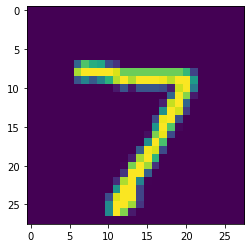

In [5]:
imgplot = plt.imshow(x_test[0])


In [17]:
latent_dim = 25


dim_dense_decoder = functools.reduce(lambda a,b : a*b, dims_data)
class Autoencoder_base(Model):
    def __init__(self, latent_dim):
        super(Autoencoder_base, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([layers.Flatten(), layers.Dense(latent_dim, activation='relu'),])
        
        self.decoder = tf.keras.Sequential([layers.Dense(dims_data[0]*dims_data[1], activation='sigmoid'),layers.Reshape(dims_data)])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
class Autoencoder_W_CNN(Model):
    def __init__(self, latent_dim):
        super(Autoencoder_W_CNN, self).__init__()
        self.latent_dim = latent_dim   
        
        self.encoder = tf.keras.Sequential([layers.Reshape((dims_data[0], dims_data[1], 1)),
                                            
                                            layers.Conv2D(32, (3, 3), activation='relu'),
                                            layers.MaxPooling2D((2, 2)),
                                            layers.Flatten(),
                                            
                                            layers.Dense(latent_dim, activation='relu') ])
        
        size_2D_latent_space = int(latent_dim**0.5)


        self.decoder = tf.keras.Sequential([
                                            
                                            layers.Reshape((size_2D_latent_space,-1,1)),
            
                                            layers.Conv2D(32, (3, 3), activation='relu'),
                                            layers.MaxPooling2D((2, 2)),
                                            layers.Flatten(),
            
                                            layers.Dense(dim_dense_decoder, activation='sigmoid'),
                                            layers.Reshape(dims_data)
                                            ])


    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder_W_CNN(latent_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.build((None, 28, 28))
autoencoder.summary()

Model: "autoencoder_w_cnn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 25)                135545    
                                                                 
 sequential_5 (Sequential)   (None, 28, 28)            26192     
                                                                 
Total params: 161,737
Trainable params: 161,737
Non-trainable params: 0
_________________________________________________________________


In [19]:
checkpoint_path = "./model/best_basic"

save_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_best_only = True,
    monitor = 'val_loss',
    verbose=1)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [21]:


load_mode = True
#load_mode = False

if load_mode :
    
    autoencoder = tf.keras.models.load_model(checkpoint_path)
    
else :
    hist = autoencoder.fit(x_train, x_train,
                callbacks=[save_callback, early_stop_callback],
                epochs=15,
                shuffle=True,
                validation_data=(x_test, x_test))

In [24]:
if not load_mode :
    fig =plt.figure()
    plt.plot(hist.history['loss'], color ='teal', label ='train_loss')
    plt.plot(hist.history['val_loss'], color ='red', label ='val_loss')
    fig.suptitle('Loss', fontsize =20)
    plt.legend(loc ="upper left")
    plt.show()
else :
    autoencoder.summary()

Model: "autoencoder_w_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 25)                135545    
                                                                 
 sequential_3 (Sequential)   (None, 28, 28)            26192     
                                                                 
Total params: 161,737
Trainable params: 161,737
Non-trainable params: 0
_________________________________________________________________


# Test

In [25]:
id_current = 15

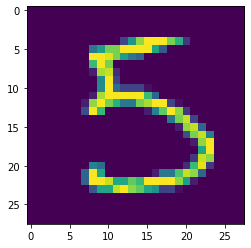

In [26]:
imgplot = plt.imshow(x_test[id_current])

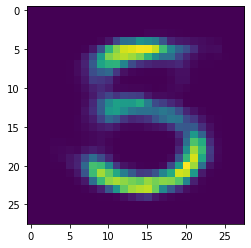

In [27]:
encoded_imgs_test = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs_test).numpy()

imgplot = plt.imshow(decoded_imgs[id_current])

<AxesSubplot:>

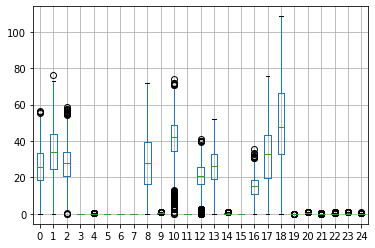

In [28]:
df_tmp = pd.DataFrame(encoded_imgs_test)
df_tmp.boxplot()

# Noise

In [29]:
def random_from_distrib(distrib) :
    #distrib = distrib.reshape(-1)

    n, size = distrib.shape
    
    
    out = np.array([rd.choice(distrib[:,j]) for j in range(size)])
    
    return out

In [30]:

def get_generated_images(model, distrib, count = 1) :
    
    noise_list = []
    for i in range(count) : 
        
        noise_list.append(random_from_distrib(distrib) ) 
        
    noise_array = np.array(noise_list)
    noise_decoded = model.decoder(noise_array).numpy()
    
    return noise_decoded




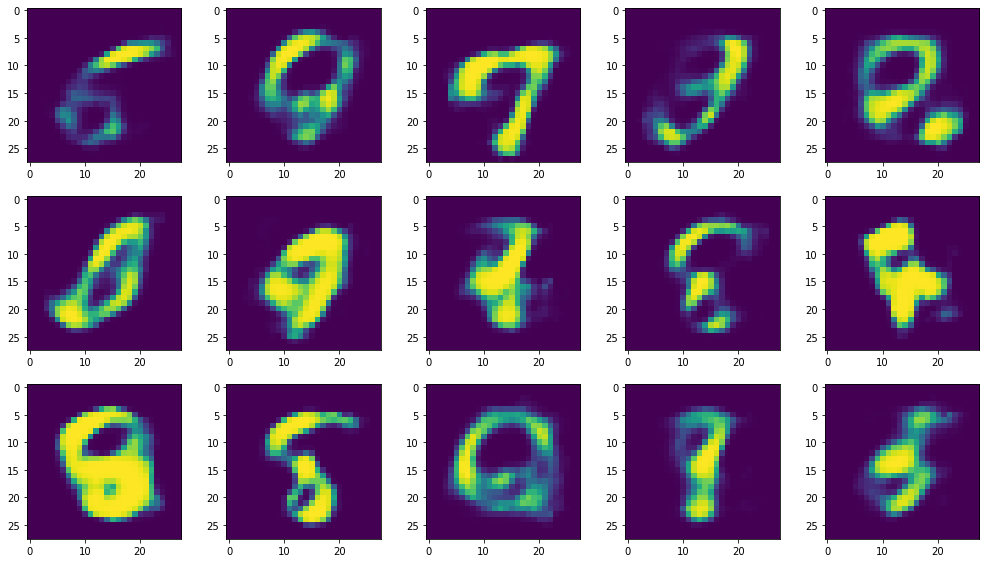

In [31]:
generated_images = get_generated_images(autoencoder,encoded_imgs_test, count = 15)
fig, ax = plt.subplots(3, 5, figsize=(14,8))
fig.tight_layout()

#create subplots
for i in range(5) :
    for j in range(3) :
        ax[j, i].imshow(generated_images[j*5+i])


# Clustering

In [32]:
encoded_imgs_test = autoencoder.encoder(x_test).numpy()


array([[3.66250610e+01, 5.00287361e+01, 4.65621719e+01, ...,
        9.55487862e-02, 3.22071373e-01, 9.28954333e-02],
       [2.57073231e+01, 2.16090488e+01, 1.76774254e+01, ...,
        2.04964001e-02, 3.97166699e-01, 1.15167983e-01],
       [3.01061668e+01, 2.73741131e+01, 2.38292313e+01, ...,
        1.27412677e-01, 9.43566933e-02, 1.41015187e-01],
       ...,
       [2.60575542e+01, 4.07847710e+01, 3.39672356e+01, ...,
        1.10072255e-01, 3.19208264e-01, 3.40628445e-01],
       [2.00127926e+01, 1.59198389e+01, 1.15436382e+01, ...,
        4.27561998e-01, 0.00000000e+00, 0.00000000e+00],
       [2.17887020e+01, 1.97456074e+01, 1.07151012e+01, ...,
        4.17712867e-01, 1.88778311e-01, 0.00000000e+00]], dtype=float32)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:31<00:00,  2.59s/it]


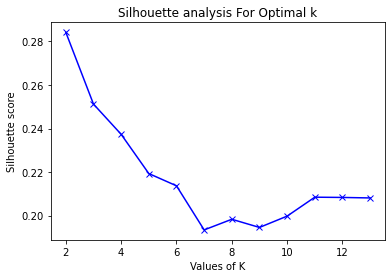

In [42]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

range_n_clusters = range(2,14)
silhouette_avg = []
for num_clusters in tqdm(range_n_clusters) :
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(encoded_imgs_test)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(encoded_imgs_test, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

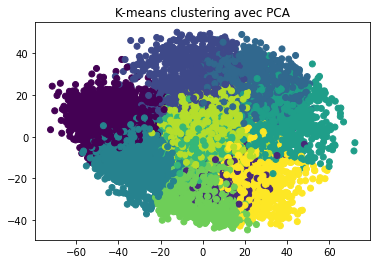

In [48]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(encoded_imgs_test)

# Réduire la dimensionnalité avec un PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(encoded_imgs_test)

# Afficher les clusters résultants avec un scatter plot
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans.labels_)
plt.title("K-means clustering avec PCA")
plt.show()